In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn.metrics import (accuracy_score, classification_report,
    confusion_matrix, precision_recall_fscore_support)

In [31]:
with open("/home/ccardellino/datasets/classes.p", "rb") as f:
    classes = pickle.load(f)

Read the filenames
------

Specify here the filenames to read the predictions, along with their abstraction level.

In [75]:
basedir_cl = '../results/echr/cl/evaluated_wordvectors_wiki/'
layers_string = '2000'
features = 'WordVectors'
outdir = '../results/echr/cl/evaluated_wordvectors_wiki/'

results_files = [
    ("NER",
     "",
     os.path.join(basedir_cl, "test_predictions_NER_%s.csv" % layers_string)
    ),
    ("ENTITY",
     "",
     os.path.join(basedir_cl, "test_predictions_NER_ENTITY_%s.csv" % layers_string)
#      os.path.join(basedir_cl, "test_predictions_ENTITY_%s.csv" % layers_string)
    ),
    ("LKIF",
     "",
     os.path.join(basedir_cl, "test_predictions_NER_ENTITY_LKIF_%s.csv" % layers_string)
#      os.path.join(basedir_cl, "test_predictions_LKIF_%s.csv" % layers_string)
    ),
    ("YAGO",
     "",
     os.path.join(basedir_cl, "test_predictions_NER_ENTITY_LKIF_YAGO_%s.csv" % layers_string)
#      os.path.join(basedir_cl, "test_predictions_YAGO_%s.csv" % layers_string)
    )
]

In [76]:
accuracy_results = []

for iteration, batch, cl in results_files:
    batch_accuracy = 0
    cl_accuracy = 0
    pvalue = 0
    if batch != "":
        batch_results = pd.read_csv(batch)
        batch_accuracy = accuracy_score(batch_results.true, batch_results.prediction)
    
    if cl != "": # and iteration != "NER":
        cl_results = pd.read_csv(cl)
        cl_accuracy = accuracy_score(cl_results.true, cl_results.prediction)
    
        if batch != "":
            _, pvalue = ttest_rel(batch_results.prediction, cl_results.prediction)
    
    accuracy_results.append({
        'iteration': iteration,
        'batch_accuracy': batch_accuracy,
        'cl_accuracy': cl_accuracy,
        'pvalue': pvalue
    })

accuracy_results = pd.DataFrame(accuracy_results).rename_axis("Index", axis="columns")

In [77]:
accuracy_results

Index,batch_accuracy,cl_accuracy,iteration,pvalue
0,0,0.555128,NER,0
1,0,0.535897,ENTITY,0
2,0,0.730769,LKIF,0
3,0,0.851282,YAGO,0


In [78]:
def read_predictions(filename, classes):
    results = pd.read_csv(filename)
    return results

In [79]:
results_df = []

for iteration, batch, cl in results_files:
    if batch != "":
        results = read_predictions(batch, classes[iteration])

        if iteration == 'NER':
            precision, recall, fscore, _ = precision_recall_fscore_support(
                results.true, results.prediction,
                labels=np.arange(classes[iteration][0].shape[0]),
                warn_for=()
            )

            prec_rec_fscore = pd.DataFrame()
            prec_rec_fscore['Class'] = classes[iteration][0]
            prec_rec_fscore['ClassCount'] = classes[iteration][1]
            prec_rec_fscore['Precision'] = precision
            prec_rec_fscore['Recall'] = recall
            prec_rec_fscore['Fscore'] = fscore
            prec_rec_fscore['Iteration'] = iteration
            prec_rec_fscore['Method'] = 'Batch Learning'

            results_df.append(prec_rec_fscore)

            continue

        precision, recall, fscore, _ = precision_recall_fscore_support(
            results.true, results.prediction,
            labels=np.arange(classes[iteration][0].shape[0] - 1),
            warn_for=()
        )

        prec_rec_fscore = pd.DataFrame()
        prec_rec_fscore['Class'] = classes[iteration][0][:-1]
        prec_rec_fscore['ClassCount'] = classes[iteration][1][:-1]
        prec_rec_fscore['Precision'] = precision
        prec_rec_fscore['Recall'] = recall
        prec_rec_fscore['Fscore'] = fscore
        prec_rec_fscore['Iteration'] = iteration
        prec_rec_fscore['Method'] = 'Batch Learning'

        results_df.append(prec_rec_fscore)
    
    if cl != "":
        results = read_predictions(cl, classes[iteration])

        precision, recall, fscore, _ = precision_recall_fscore_support(
            results.true, results.prediction,
            labels=np.arange(classes[iteration][0].shape[0] - 1),
            warn_for=()
        )

        prec_rec_fscore = pd.DataFrame()
        prec_rec_fscore['Class'] = classes[iteration][0][:-1]
        prec_rec_fscore['ClassCount'] = classes[iteration][1][:-1]
        prec_rec_fscore['Precision'] = precision
        prec_rec_fscore['Recall'] = recall
        prec_rec_fscore['Fscore'] = fscore
        prec_rec_fscore['Iteration'] = iteration
        prec_rec_fscore['Method'] = 'Curriculum Learning'

        results_df.append(prec_rec_fscore)

results_df = pd.concat(results_df)
results_df = pd.melt(results_df, id_vars=["Class", "ClassCount", "Iteration", "Method"],
                     value_vars=["Precision", "Fscore", "Recall"],
                     var_name="Metric", value_name="Value")

metric_map = {"Precision": 0, "Recall": 1, "Fscore": 2}
results_df['MetricRank'] = results_df['Metric'].map(metric_map)
results_df = results_df.sort_values(["Iteration", "Method", "MetricRank", "Class"]).reset_index(drop=True)

Print results as a latex table

In [ ]:
pivot_df = results_df[(results_df.Iteration == 'YAGO')]

pivot_df = pivot_df.pivot_table(index=['Class', 'Method'],
                                columns='Metric', values='Value')[['Precision', 'Recall', 'Fscore']].reset_index()

pivot_df = pivot_df.append(pivot_df[pivot_df.Method == 'Batch Learning'].mean(), ignore_index=True)
pivot_df = pivot_df.append(pivot_df[pivot_df.Method == 'Curriculum Learning'].mean(), ignore_index=True)
pivot_df = pivot_df[['Precision', 'Recall', 'Fscore']]
print(pivot_df.to_latex(index=False, float_format=lambda x: '%.2f' % x))

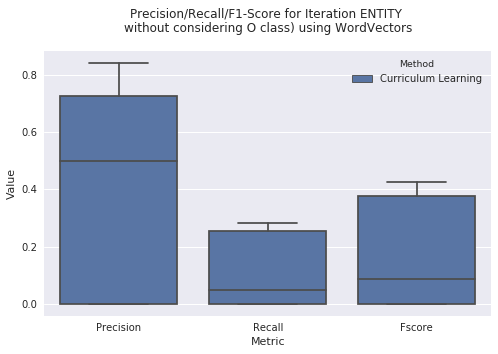

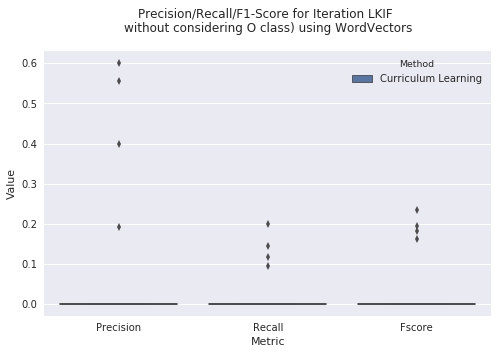

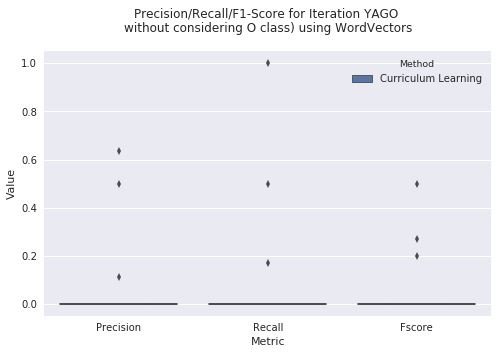

In [80]:
for iteration, idf in results_df.groupby("Iteration"):
    if iteration == "NER":
        continue
    
    plt.clf()

    ax = sns.boxplot(x='Metric', y='Value', hue='Method',
                     data=idf)
    ax.set_title('Precision/Recall/F1-Score for Iteration %s \nwithout considering O class) using %s'
                 % (iteration, features))
    ax.title.set_y(1.05)
    ax.figure.set_size_inches(7, 5)
    ax.figure.tight_layout(pad=1)
    ax.figure.savefig(os.path.join(outdir, 'prec_rec_fscore/%s_prec_rec_fscore.png' % (iteration, )))
    plt.show()

In [81]:
rdf_top_bottom = []

for (iteration, method), rdf in results_df.groupby(["Iteration", "Method"]):
    if iteration == 'NER':
        continue
    
    prec_rdf = rdf[rdf.Metric == 'Precision']
    rec_rdf = rdf[rdf.Metric == 'Recall']
    fscore_rdf = rdf[rdf.Metric == 'Fscore']

    to_take = np.ceil(prec_rdf.shape[0] * 0.2).astype(np.int32)

    bottom_prec = prec_rdf.sort_values('ClassCount', ascending=False)[:to_take].Value.mean()
    top_prec = prec_rdf.sort_values('ClassCount', ascending=True)[:to_take].Value.mean()
    bottom_rec = rec_rdf.sort_values('ClassCount', ascending=False)[:to_take].Value.mean()
    top_rec = rec_rdf.sort_values('ClassCount', ascending=True)[:to_take].Value.mean()
    bottom_fscore = fscore_rdf.sort_values('ClassCount', ascending=False)[:to_take].Value.mean()
    top_fscore = fscore_rdf.sort_values('ClassCount', ascending=True)[:to_take].Value.mean()

    rdf_top_bottom.append({
        'Iteration': iteration,
#         'Method': method,
        'Top 20% Precision Mean': top_prec,
        'Bottom 20% Precision Mean': bottom_prec,
        'Top 20% Recall Mean': top_rec,
        'Bottom 20% Recall Mean': bottom_rec,
        'Top 20% Fscore Mean': top_fscore,
        'Bottom 20% Fscore Mean': bottom_fscore,
    })

rdf_top_bottom = pd.DataFrame(rdf_top_bottom,
                              columns=['Iteration', 'Top 20% Precision Mean', 'Bottom 20% Precision Mean',
                                      'Top 20% Recall Mean', 'Bottom 20% Recall Mean', 'Top 20% Fscore Mean',
                                      'Bottom 20% Fscore Mean'])


In [82]:
rdf_top_bottom.rename_axis("Index", axis="columns")

Index,Iteration,Top 20% Precision Mean,Bottom 20% Precision Mean,Top 20% Recall Mean,Bottom 20% Recall Mean,Top 20% Fscore Mean,Bottom 20% Fscore Mean
0,ENTITY,0.0,0.727273,0.0,0.253968,0.0,0.376471
1,LKIF,0.0,0.100000,0.0,0.029412,0.0,0.045455
2,YAGO,0.0,0.025455,0.0,0.006829,0.0,0.010769


In [47]:
print(rdf_top_bottom.to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrrrr}
\toprule
Iteration &  Top 20\% Precision Mean &  Bottom 20\% Precision Mean &  Top 20\% Recall Mean &  Bottom 20\% Recall Mean &  Top 20\% Fscore Mean &  Bottom 20\% Fscore Mean \\
\midrule
   ENTITY &                     0.0 &                       0.43 &                  0.0 &                    0.19 &                  0.0 &                    0.26 \\
     LKIF &                     0.0 &                       0.00 &                  0.0 &                    0.00 &                  0.0 &                    0.00 \\
     YAGO &                     0.0 &                       0.05 &                  0.0 &                    0.01 &                  0.0 &                    0.02 \\
\bottomrule
\end{tabular}



In [83]:
confusion_matrices = {}
columns = {}

for iteration, batch, cl in results_files:
    if iteration == 'NER' or iteration == 'YAGO':
        continue
    
    classes_ = np.array([re.sub('^I-', '', cls) for cls in classes[iteration][0]])
    
    if batch != "":
        batch_df = read_predictions(batch, classes[iteration])
        confusion_matrices[('batch', iteration)] =\
            confusion_matrix(batch_df.true, batch_df.prediction, labels=np.arange(classes_.shape[0]))
        columns[('batch', iteration)] = classes_
    
    if cl != "":
        cl_df = read_predictions(cl, classes[iteration])
        confusion_matrices[('cl', iteration)] =\
            confusion_matrix(cl_df.true, cl_df.prediction, labels=np.arange(classes_.shape[0]))
        columns[('cl', iteration)] = classes_

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


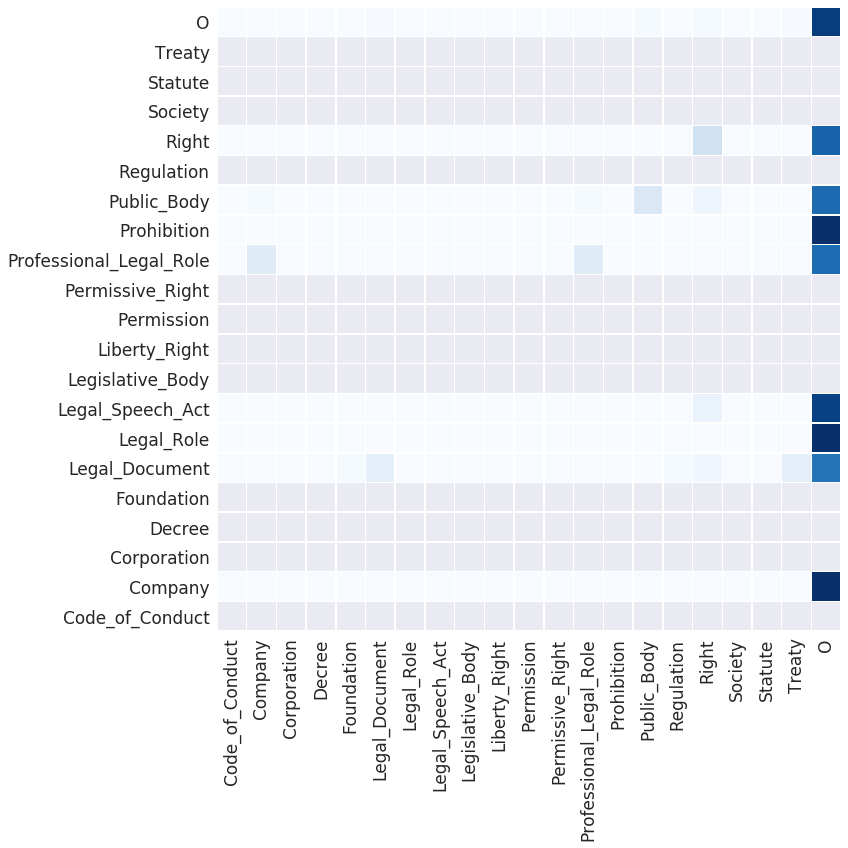

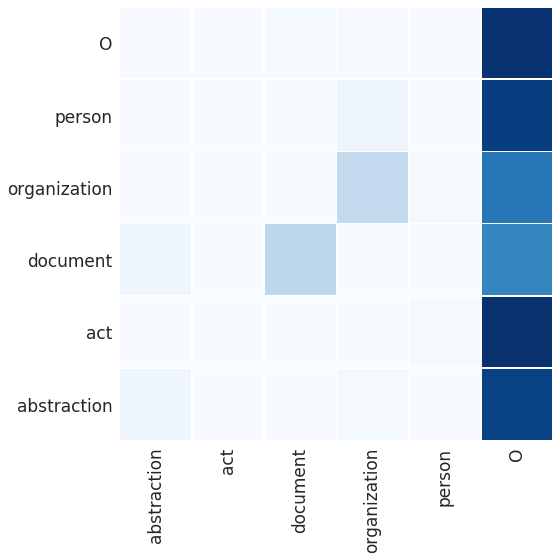

In [84]:
for (method, iteration), cm in confusion_matrices.items():
    plt.clf()

    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    normalized_cm = pd.DataFrame(normalized_cm, columns=columns[(method, iteration)],
                                 index=columns[(method, iteration)])

    ax = sns.heatmap(normalized_cm.reindex(index=normalized_cm.index[::-1]), vmin=0.0, vmax=1.0, annot=False,
                     fmt=".2f", linewidths=.5, cmap="Blues", cbar=False)
    method_name = 'Batch Learning' if method == 'batch' else 'Curriculum Learning'
#     ax.set_title("Confusion Matrix Normalized Heatmap\nfor %s and Iteration %s using %s"
#                  % (method_name, iteration, features))

    ax.tick_params(labelsize=17)
    plt.xticks(rotation=90)
    if iteration == 'ENTITY':
        plt.yticks(rotation=0)
    
    ax.title.set_y(1.05)
    
    if iteration == 'LKIF':
        ax.figure.set_size_inches(12, 12)
    else:
        ax.figure.set_size_inches(8, 8)
    
    ax.figure.tight_layout(pad=1.5)
    
    ax.figure.savefig(
        '%s/heatmaps/%s_%s_heatmaps.png' % (outdir, method, iteration))
    plt.show()

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in true_divide


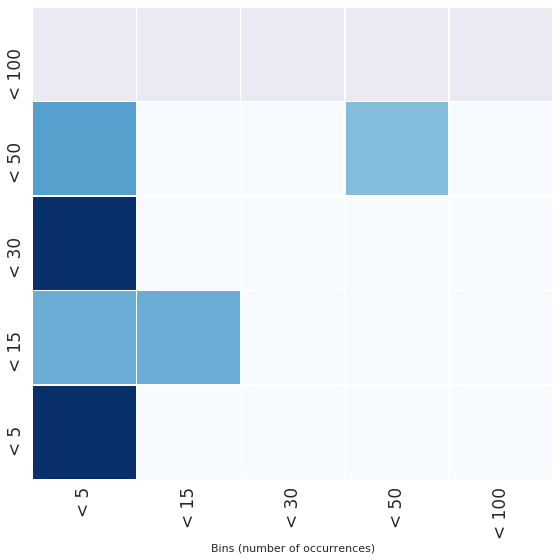

In [85]:
def mapping(label):
    if counts[label] < 5:
        return "< 5"
    elif counts[label] < 15:
        return "< 15"
    elif counts[label] < 30:
        return "< 30"
    elif counts[label] < 50:
        return "< 50"
    elif counts[label] < 100:
        return "< 100"
    else:
        return "O"

vmapping = np.vectorize(mapping)
# bins = ["< 5", "< 15", "< 30", "< 50", "< 100", "< 200", "< 500",
#         "< 1000", "< 2000", "< 5000", "< 10000", "< 15000",
#         "< 30000", "< 50000", "< 1000000", "O"]
bins = ["< 5", "< 15", "< 30", "< 50", "< 100"]

_, batch, cl = results_files[-1]

for method, method_file in [('batch', batch), ('cl', cl)]:
    if method_file != "":
        df = pd.read_csv(method_file)

        counts = {}
        for label_index in range(classes['YAGO'][0].shape[0]):
            counts[label_index] = (df.true == label_index).sum()

        true_mapped = vmapping(df.true.values)
        prediction_mapped = vmapping(df.prediction.values)

        cm = confusion_matrix(true_mapped, prediction_mapped, labels=bins)

        plt.clf()
    
        normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        normalized_cm = pd.DataFrame(normalized_cm, columns=bins,
                                     index=bins)

        ax = sns.heatmap(normalized_cm.reindex(index=normalized_cm.index[::-1]), vmin=0.0, vmax=1.0, annot=False,
                         fmt=".2f", linewidths=.5, cmap="Blues", cbar=False)
        method_name = 'Batch Learning' if method == 'batch' else 'Curriculum Learning'
    #     ax.set_title("Confusion Matrix Normalized Heatmap\nfor %s and Iteration YAGO using %s"
    #                  % (method_name, features))

        ax.tick_params(labelsize=17)
        plt.xticks(rotation=90)

        ax.title.set_y(1.05)

        ax.set_xlabel('Bins (number of occurrences)')

        ax.figure.set_size_inches(8, 8)

        ax.figure.tight_layout(pad=1.5)

        ax.figure.savefig(
            '%s/heatmaps/%s_YAGO_heatmaps.png' % (outdir, method))

Get average precision and recall

In [86]:
averages = ['micro', 'macro', 'weighted']
levels = [(iteration[0], average) for iteration in results_files for average in averages]
index = pd.MultiIndex.from_tuples(levels, names=['Task', 'Average type'])

batch_metrics = pd.DataFrame(0, index=index, columns=['Precision', 'Recall', 'F1 Score'])
cl_metrics = pd.DataFrame(0, index=index, columns=['Precision', 'Recall', 'F1 Score'])
for iteration, batch, cl in results_files:
    if batch != "":
        results = read_predictions(batch, classes[iteration])
        for average in averages:
            values = precision_recall_fscore_support(
                results.true, results.prediction,
                average=average, warn_for=()
            )[:3]
            print(values)

            batch_metrics.loc[iteration, average] = values
    if cl != "":
        results = read_predictions(cl, classes[iteration])
        for average in averages:
            values = precision_recall_fscore_support(
                results.true, results.prediction,
                average=average, warn_for=()
            )[:3]

            cl_metrics.loc[iteration, average] = values

In [87]:
cl_metrics.rename_axis("Index", axis="columns")

Index                Precision    Recall  F1 Score
Task   Average type                               
NER    micro          0.555128  0.555128  0.555128
       macro          0.707345  0.561592  0.464420
       weighted       0.710138  0.555128  0.461029
ENTITY micro          0.535897  0.535897  0.535897
       macro          0.431442  0.261624  0.261561
       weighted       0.435497  0.535897  0.413283
LKIF   micro          0.730769  0.730769  0.730769
       macro          0.209695  0.125588  0.135228
       weighted       0.670849  0.730769  0.670014
YAGO   micro          0.851282  0.851282  0.851282
       macro          0.107797  0.130863  0.094817
       weighted       0.840842  0.851282  0.838199